In [1]:
%load_ext autotime

time: 210 µs


In [3]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow_probability as tfp
import time

In [4]:
import tensorflow.compat.v1.keras.backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [7]:
from keras.datasets import mnist
img_rows, img_cols = 28, 28

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1).astype('float32')
input_shape = (img_rows, img_cols, 1)

x_train /= 255
x_test /= 255

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

Using TensorFlow backend.


x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model, Model

import tensorflow.compat.v1.keras.backend as K
from tensorflow.keras import metrics

In [9]:
img_shape = (28, 28, 1)    # for MNIST
batch_size = 100
latent_dim = 10  # Number of latent dimension parameters

In [7]:
# Encoder architecture: Input -> Conv2D*4 -> Flatten -> Dense
from tensorflow import keras

input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3,
                  padding='same', 
                  activation='relu')(input_img)
x = layers.Conv2D(64, 3,
                  padding='same', 
                  activation='relu',
                  strides=(2, 2))(x)
x = layers.Conv2D(64, 3,
                  padding='same', 
                  activation='relu')(x)
x = layers.Conv2D(64, 3,
                  padding='same', 
                  activation='relu')(x)

shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

# Two outputs, latent mean and (log)variance
z_mu = layers.Dense(latent_dim)(x)
z_log_sigma = layers.Dense(latent_dim)(x)

def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mu + K.exp(z_log_sigma) * epsilon

# sample vector from the latent distribution
z = layers.Lambda(sampling)([z_mu, z_log_sigma])

decoder_input = layers.Input(K.int_shape(z)[1:])

# Expand to 784 total pixels
x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

# reshape
x = layers.Reshape(shape_before_flattening[1:])(x)

# use Conv2DTranspose to reverse the conv layers from the encoder
x = layers.Conv2DTranspose(32, 3,
                           padding='same', 
                           activation='relu',
                           strides=(2, 2))(x)
x = layers.Conv2D(1, 3,
                  padding='same', 
                  activation='sigmoid')(x)

# decoder model statement
decoder = Model(decoder_input, x)

# apply the decoder to the sample from the latent distribution
z_decoded = decoder(z)

class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        # Reconstruction loss
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_log_sigma - K.square(z_mu) - K.exp(z_log_sigma), axis=-1)
        return K.mean(xent_loss + kl_loss)

    # adds the custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

y = CustomVariationalLayer()([input_img, z_decoded])

time: 495 ms


In [8]:
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

vae.fit(
    x=x_train, y=None,
    shuffle=True,
    epochs=10,
    batch_size=batch_size,
    validation_data=(x_test, None))

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 64)   18496       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_1[0][0]                   
____________________________________________________________________________________________

/usr/local/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


60000/60000 [==============================] - 145s 2ms/sample - loss: 0.2146 - val_loss: 0.1454
Epoch 2/10
60000/60000 [==============================] - 172s 3ms/sample - loss: 0.1385 - val_loss: 0.1320
Epoch 3/10
60000/60000 [==============================] - 163s 3ms/sample - loss: 0.1252 - val_loss: 0.1204
Epoch 4/10
60000/60000 [==============================] - 145s 2ms/sample - loss: 0.1190 - val_loss: 0.1139
Epoch 5/10
60000/60000 [==============================] - 179s 3ms/sample - loss: 0.1146 - val_loss: 0.1117
Epoch 6/10
60000/60000 [==============================] - 184s 3ms/sample - loss: 0.1103 - val_loss: 0.1087
Epoch 7/10
60000/60000 [==============================] - 176s 3ms/sample - loss: 0.1077 - val_loss: 0.1053
Epoch 8/10
60000/60000 [==============================] - 175s 3ms/sample - loss: 0.1059 - val_loss: 0.1055
Epoch 9/10
60000/60000 [==============================] - 185s 3ms/sample - loss: 0.1046 - val_loss: 0.1038
Epoch 10/10
60000/60000 [==============

time: 27min 54s


In [9]:
encoder = Model(input_img, z_mu)

x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
x_test_decoded = decoder.predict(x_test_encoded, batch_size=batch_size)

time: 5.47 s


In [10]:
import tensorflow as tf

teacher_model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
  tf.keras.layers.Dense(20,activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

teacher_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy'],
)

time: 86.3 ms


In [11]:
teacher_model.summary()
teacher_model.fit(
    x_train,
    y_train,
    epochs=2,
    validation_data=(x_test,y_test),
    verbose=2,
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 20)                15700     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                210       
Total params: 15,910
Trainable params: 15,910
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 - 2s - loss: 0.4031 - accuracy: 0.8881 - val_loss: 0.2403 - val_accuracy: 0.9317
Epoch 2/2
60000/60000 - 2s - loss: 0.2243 - accuracy: 0.9362 - val_loss: 0.2026 - val_accuracy: 0.9414


time: 3.81 s


/usr/local/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


time: 296 ms


# New script from here

In [1]:
# encoder.save('./encoder')
# decoder.save("./decoder")
# teacher_model.save("./teacher_model")

In [5]:
encoder=tf.keras.models.load_model('./encoder')
decoder=tf.keras.models.load_model("./decoder")
teacher_model=tf.keras.models.load_model("./teacher_model")

In [10]:
test_pred = np.argmax(teacher_model.predict(x_test), axis=-1)

/usr/local/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


0 1
0 2
0 3
0 4
0 5
0 6


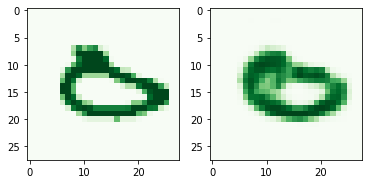

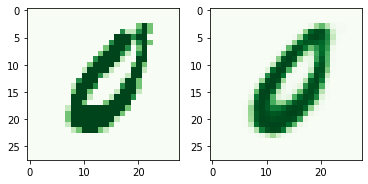

0 7


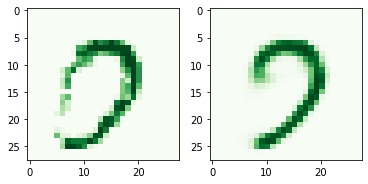

0 8
0 9
1 0
1 2


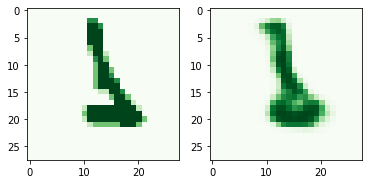

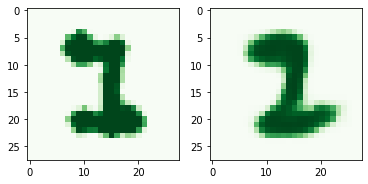

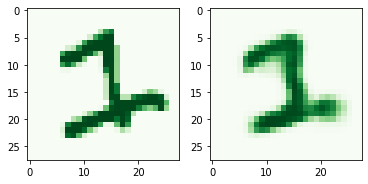

1 3
1 4
1 5
1 6


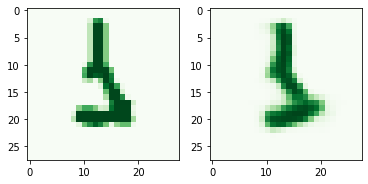

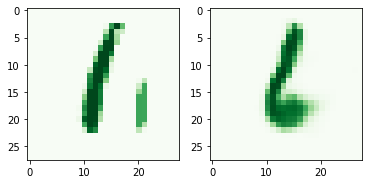

1 7
1 8


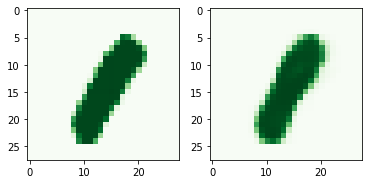

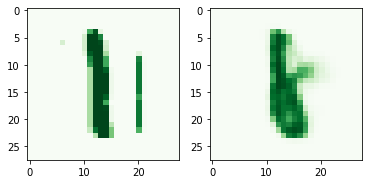

1 9
2 0


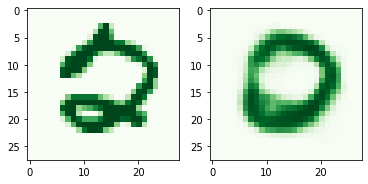

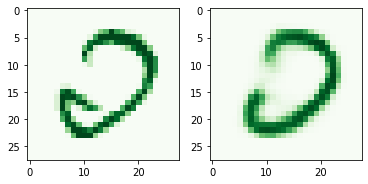

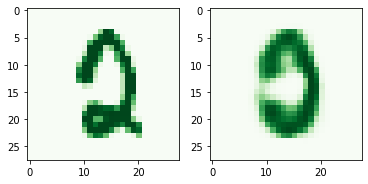

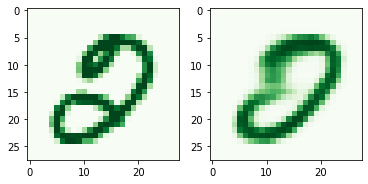

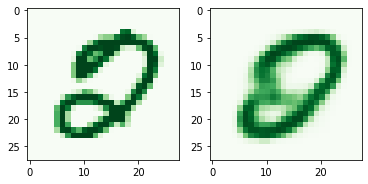

2 1


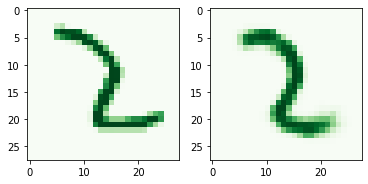

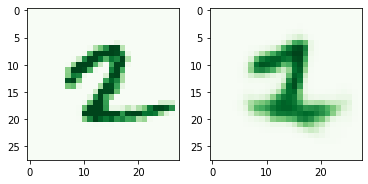

2 3


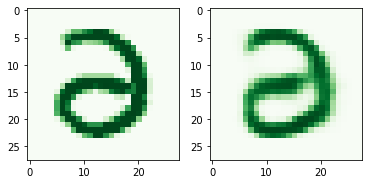

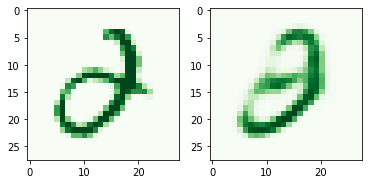

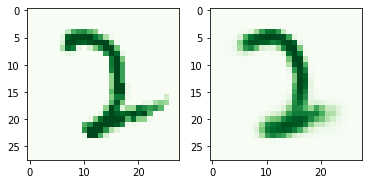

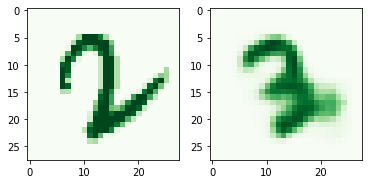

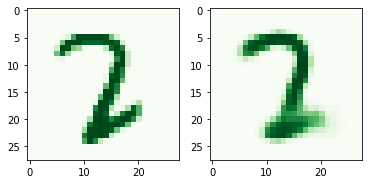

2 4


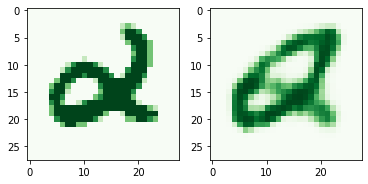

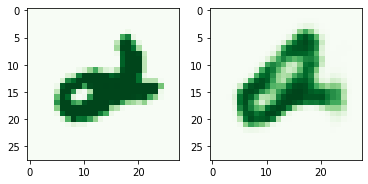

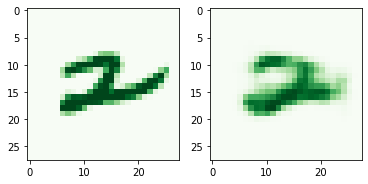

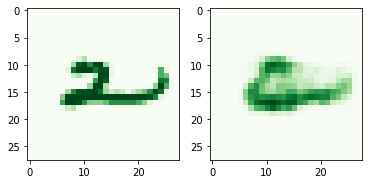

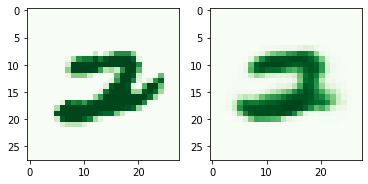

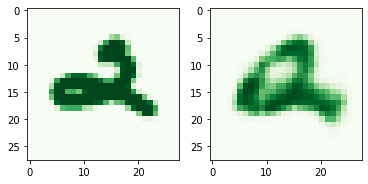

2 5


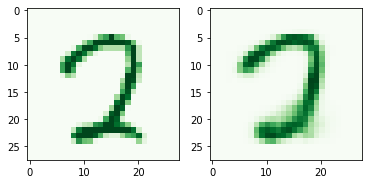

2 6


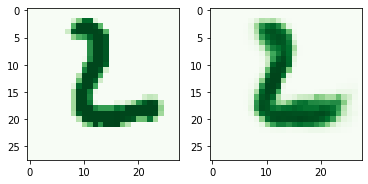

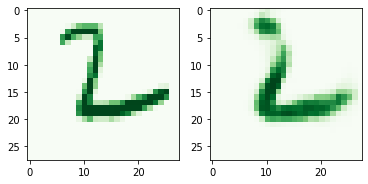

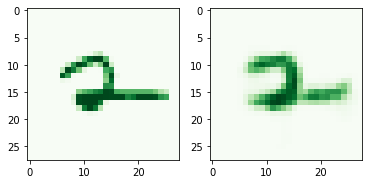

2 7


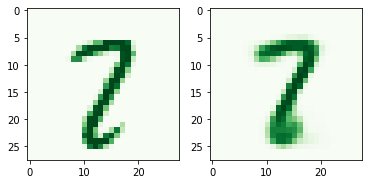

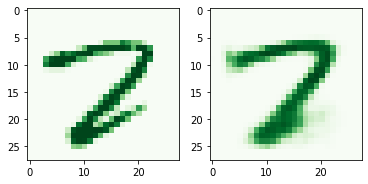

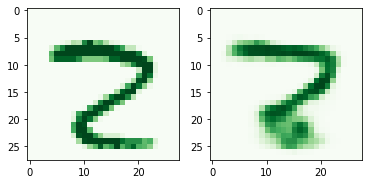

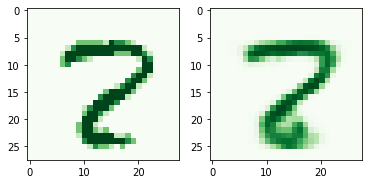

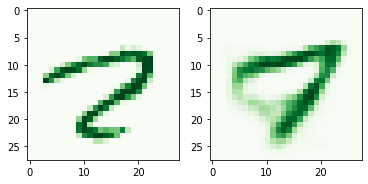

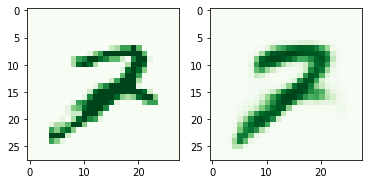

2 8


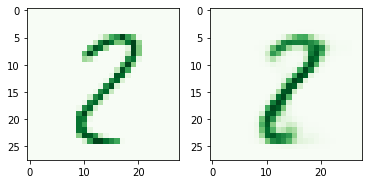

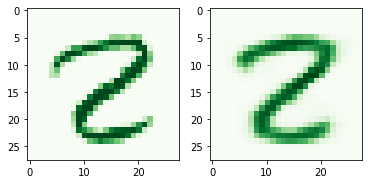

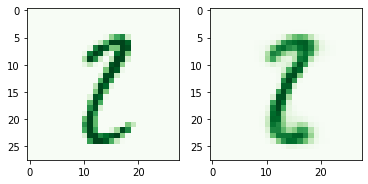

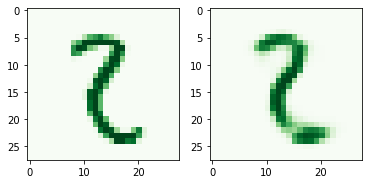

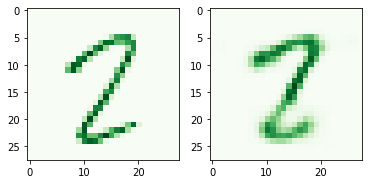

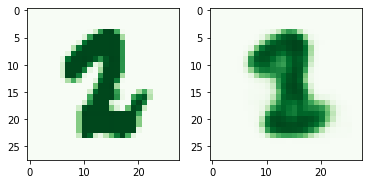

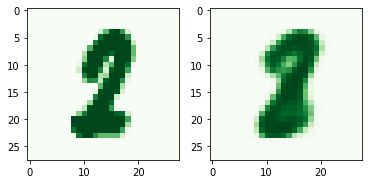

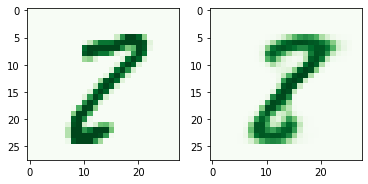

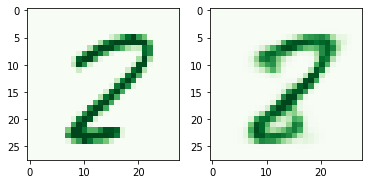

2 9
3 0
3 1
3 2


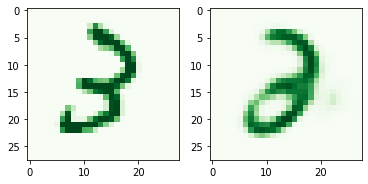

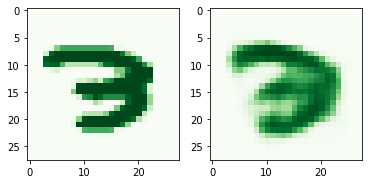

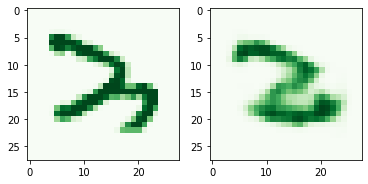

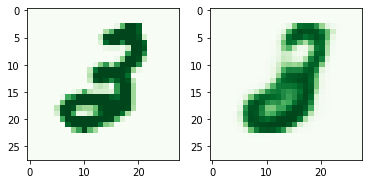

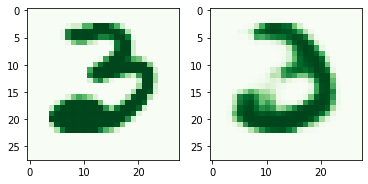

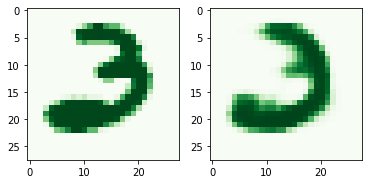

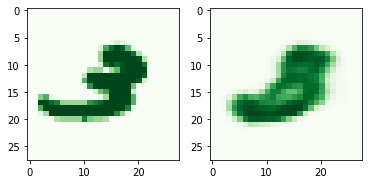

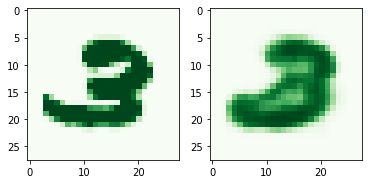

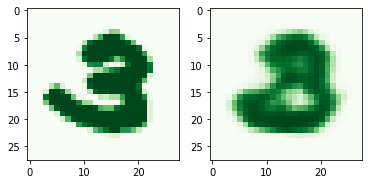

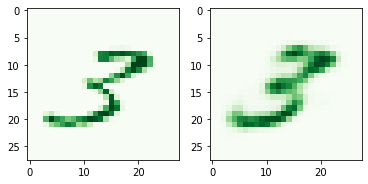

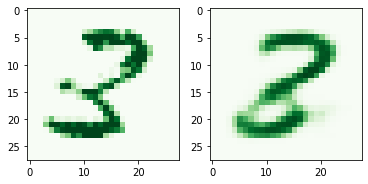

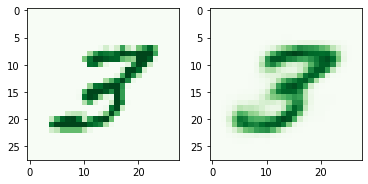

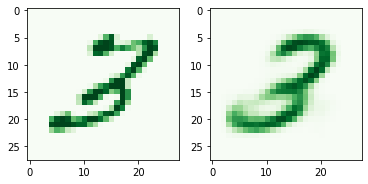

3 4
3 5


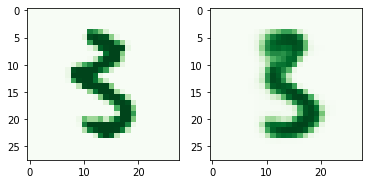

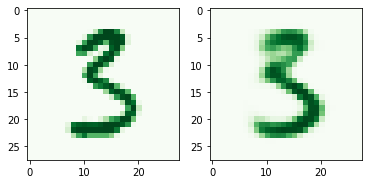

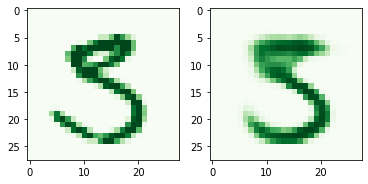

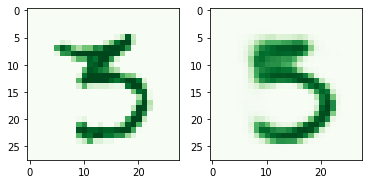

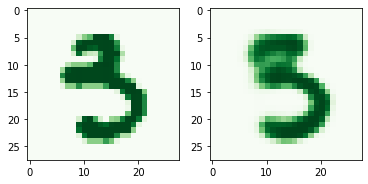

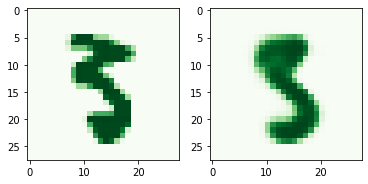

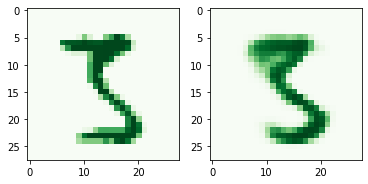

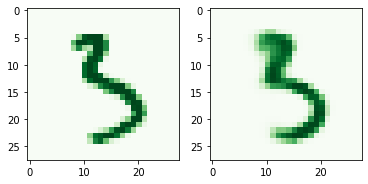

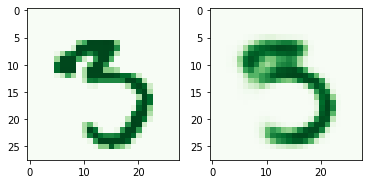

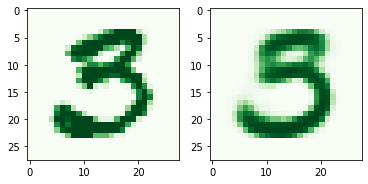

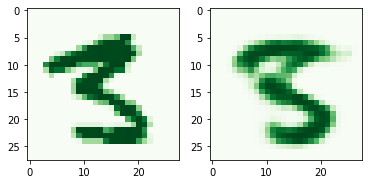

3 6
3 7


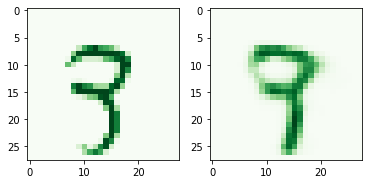

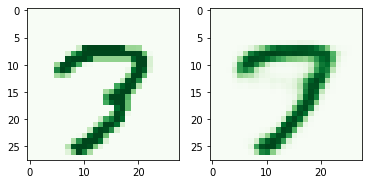

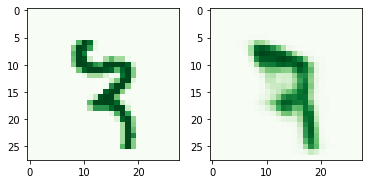

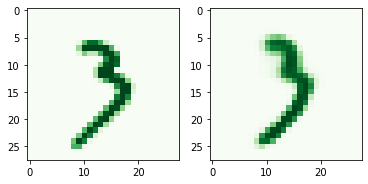

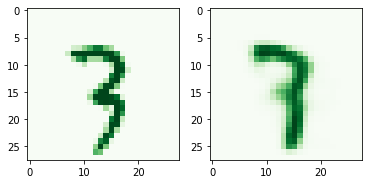

3 8


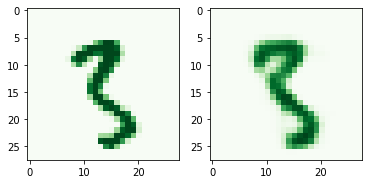

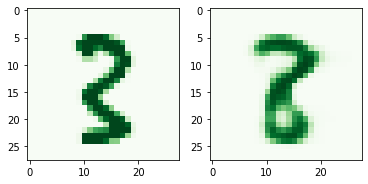

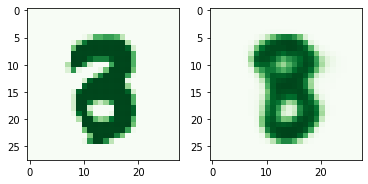

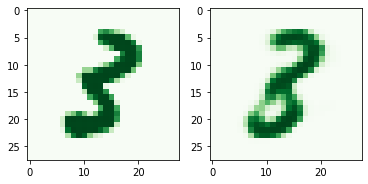

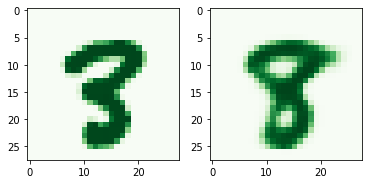

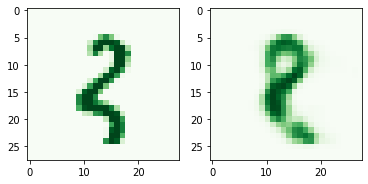

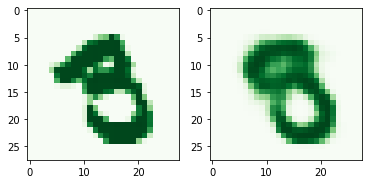

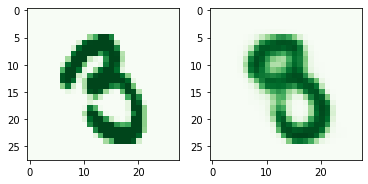

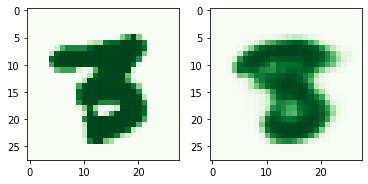

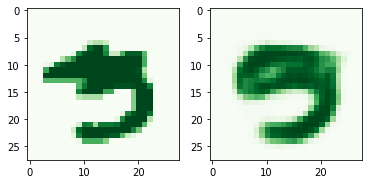

3 9
4 0
4 1


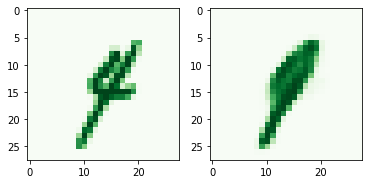

4 2


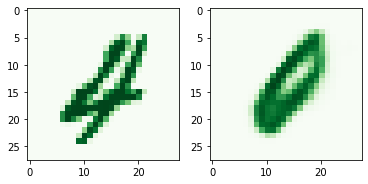

4 3


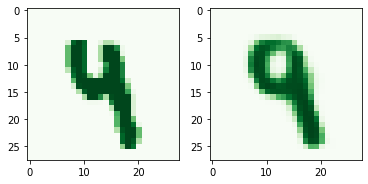

4 5
4 6


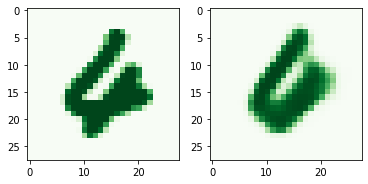

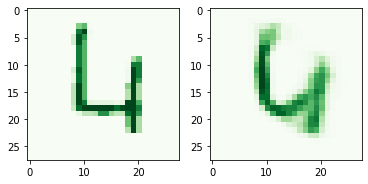

4 7
4 8


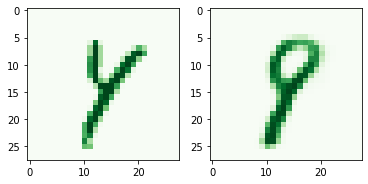

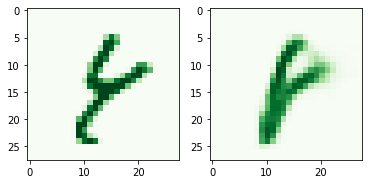

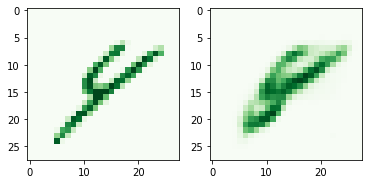

4 9


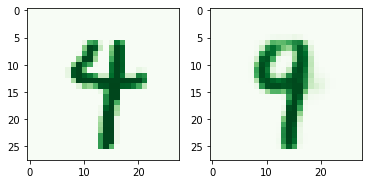

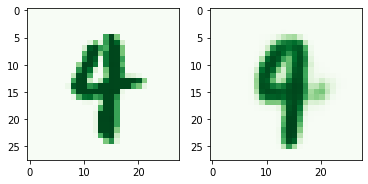

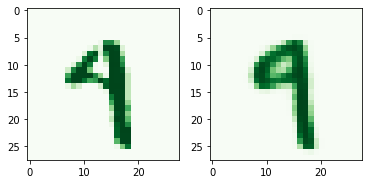

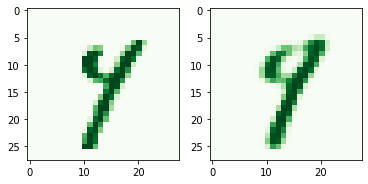

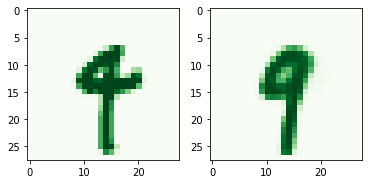

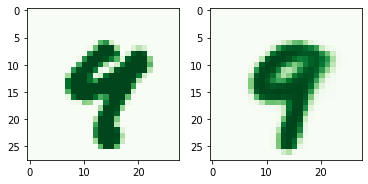

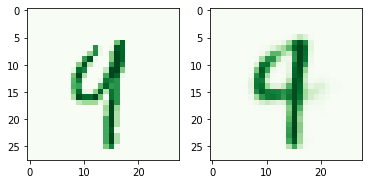

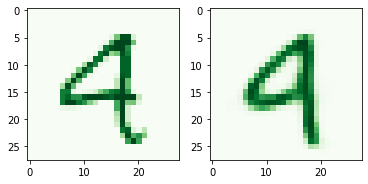

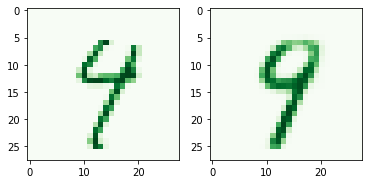

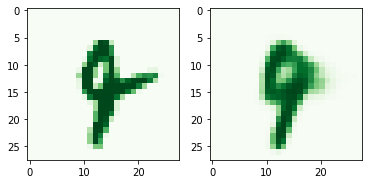

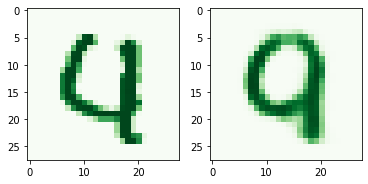

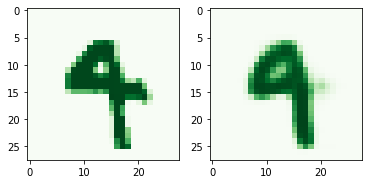

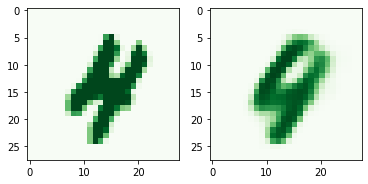

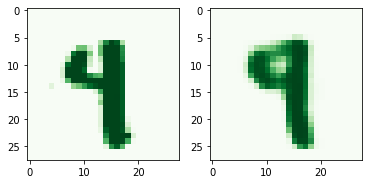

5 0


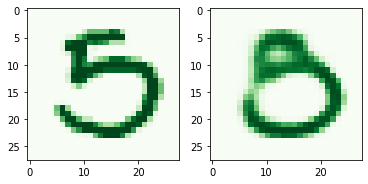

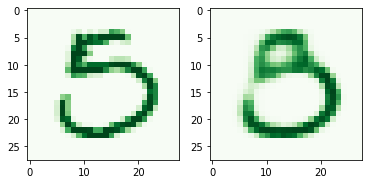

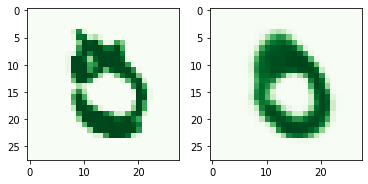

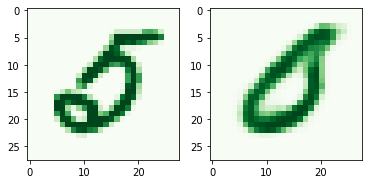

5 1


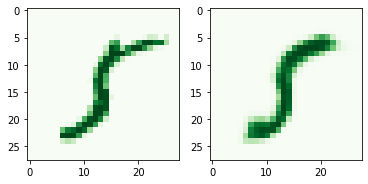

5 2
5 3


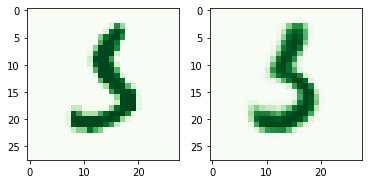

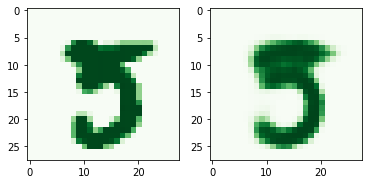

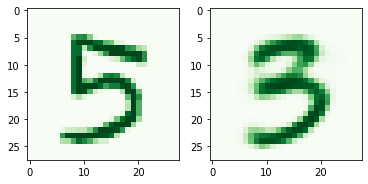

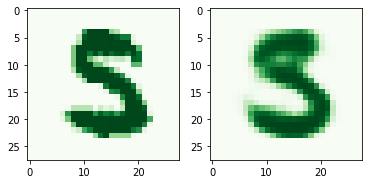

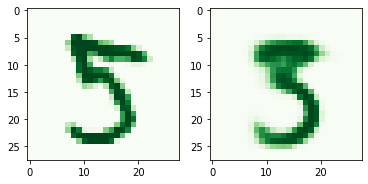

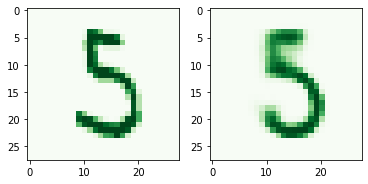

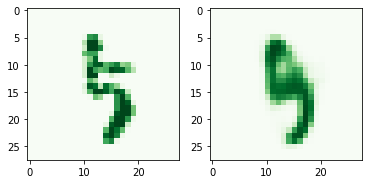

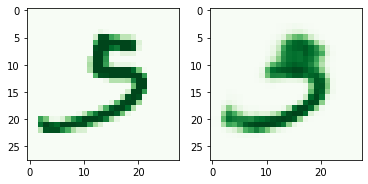

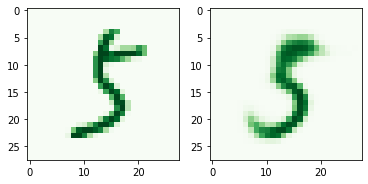

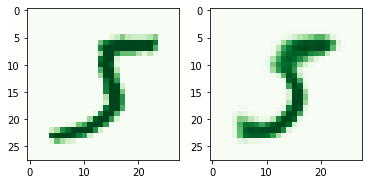

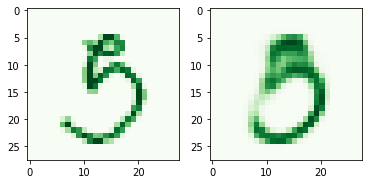

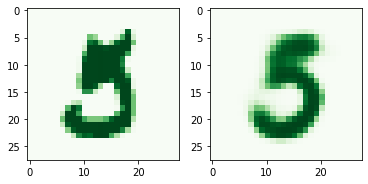

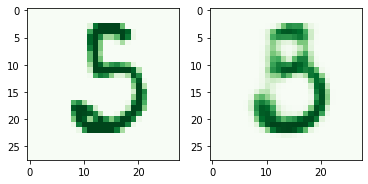

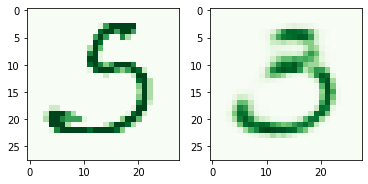

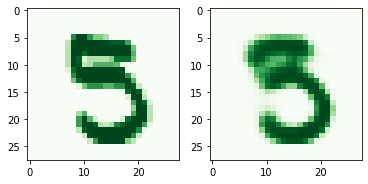

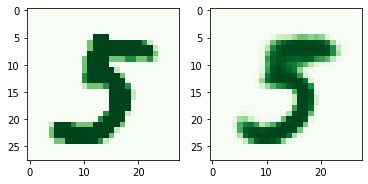

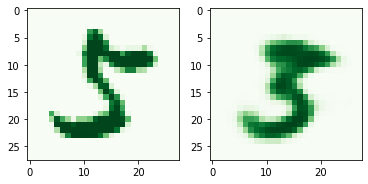

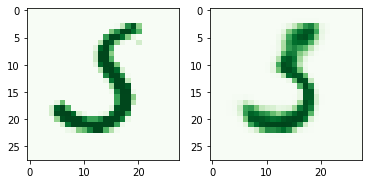

5 4
5 6


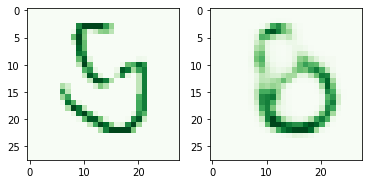

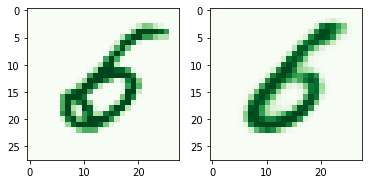

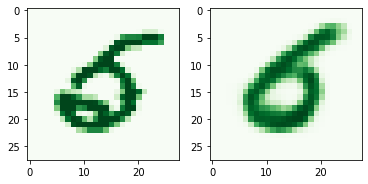

5 7
5 8


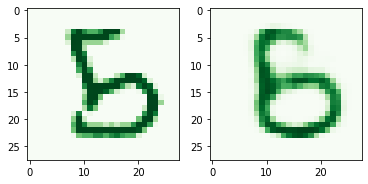

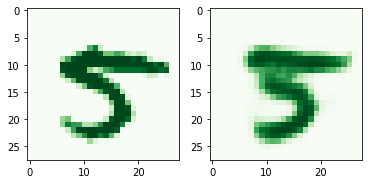

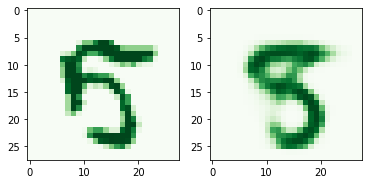

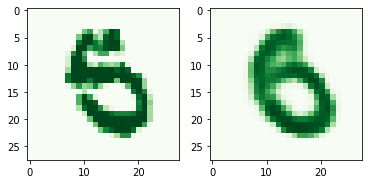

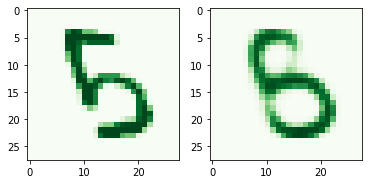

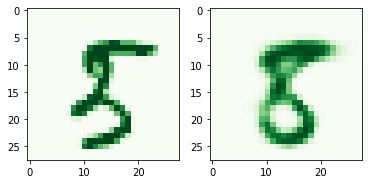

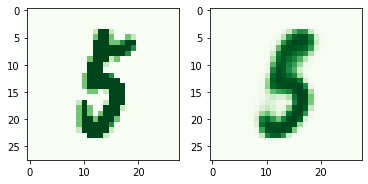

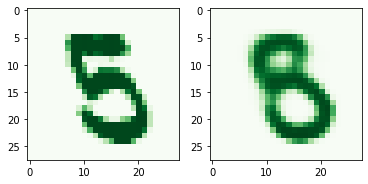

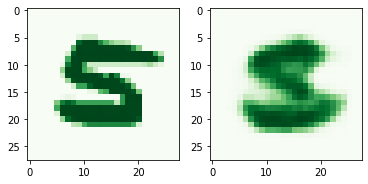

5 9


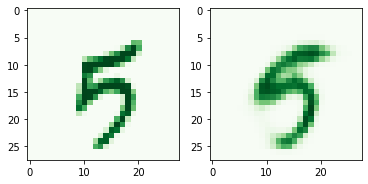

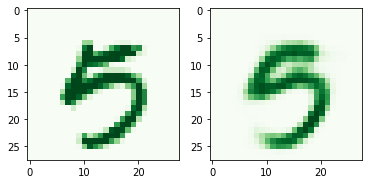

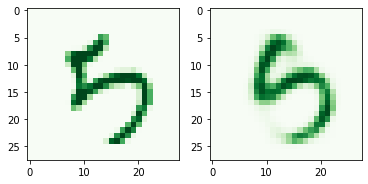

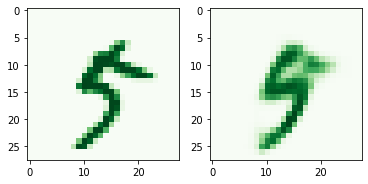

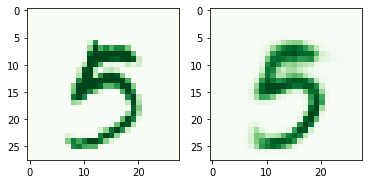

6 0


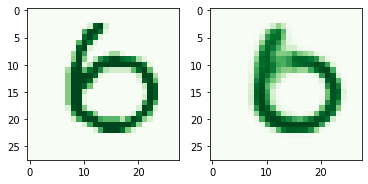

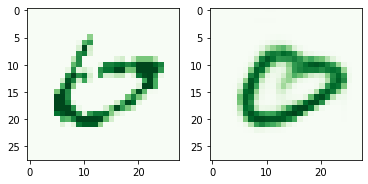

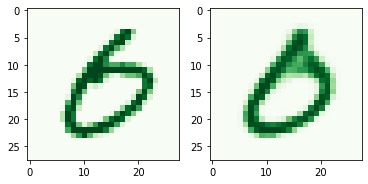

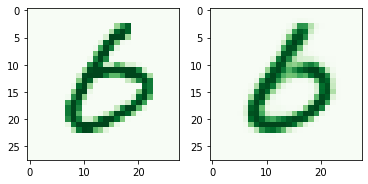

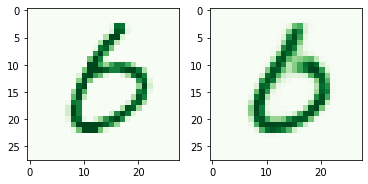

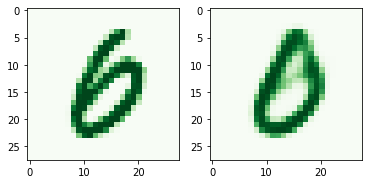

6 1


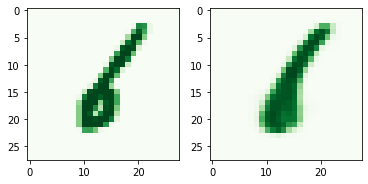

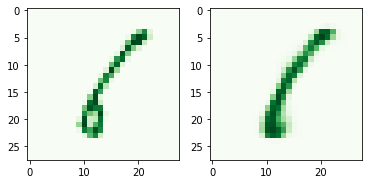

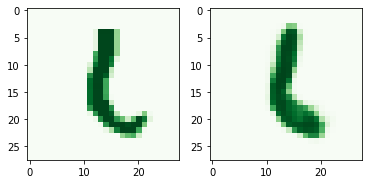

6 2
6 3
6 4


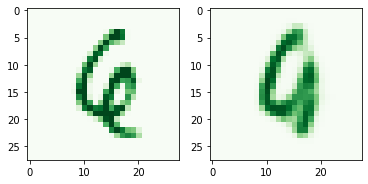

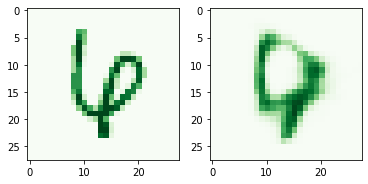

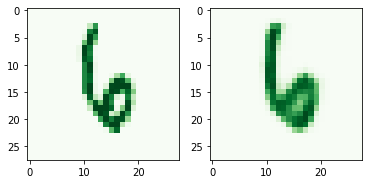

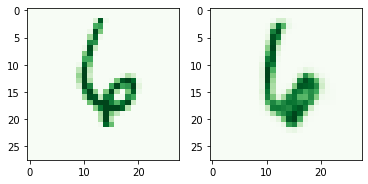

6 5


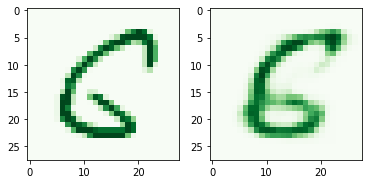

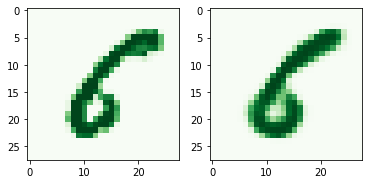

6 7
6 8


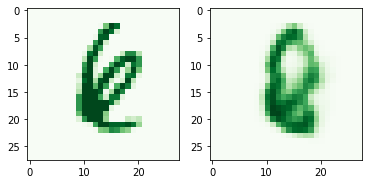

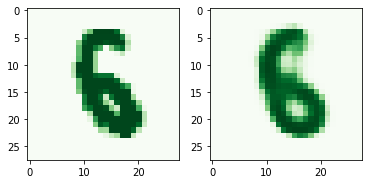

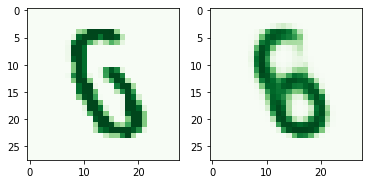

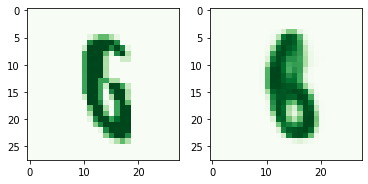

6 9
7 0


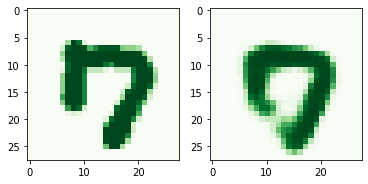

7 1


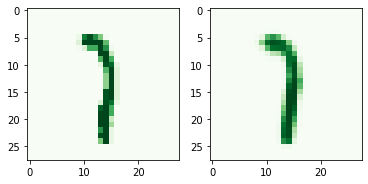

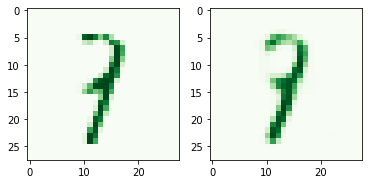

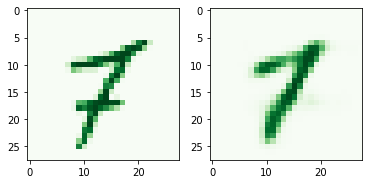

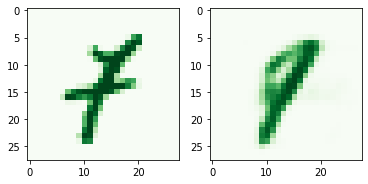

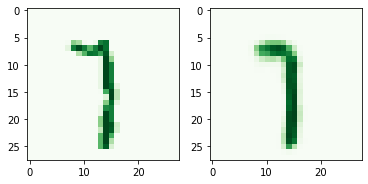

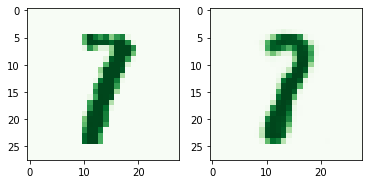

7 2


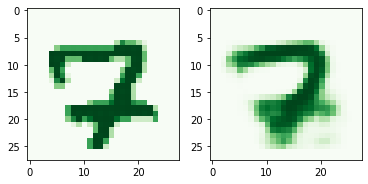

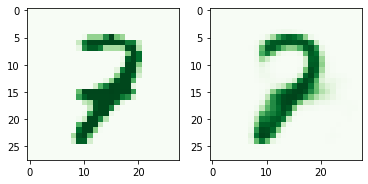

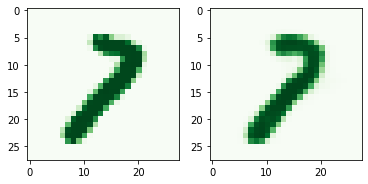

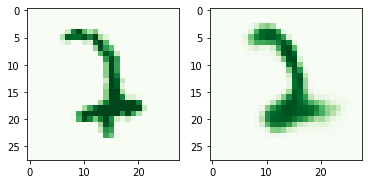

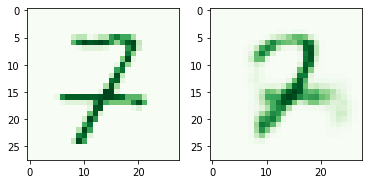

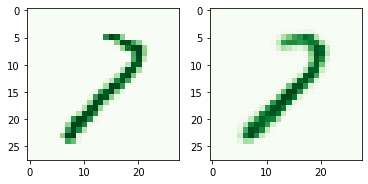

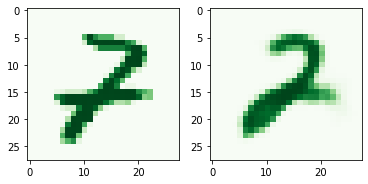

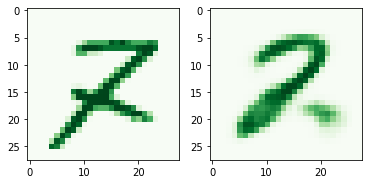

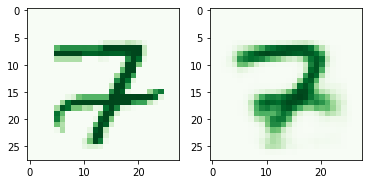

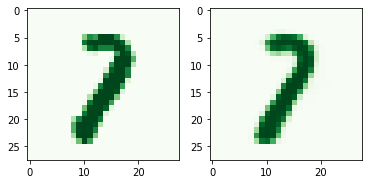

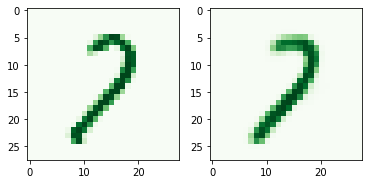

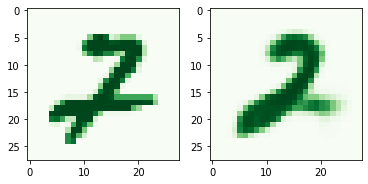

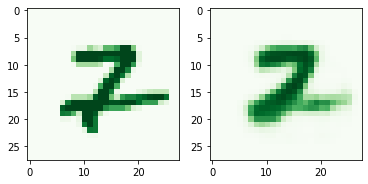

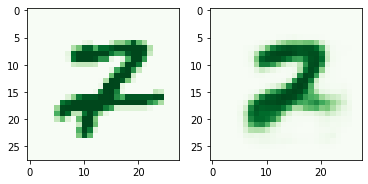

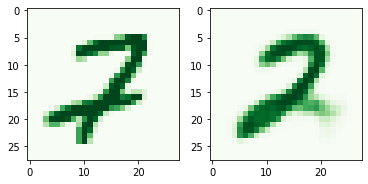

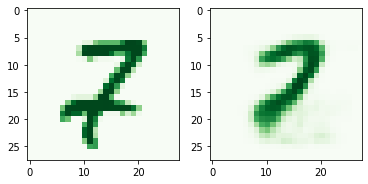

7 3


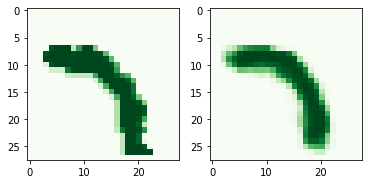

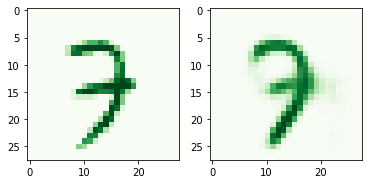

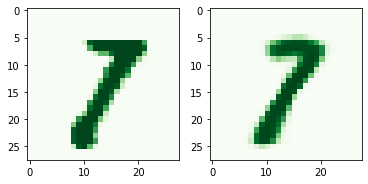

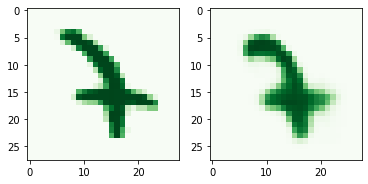

7 4


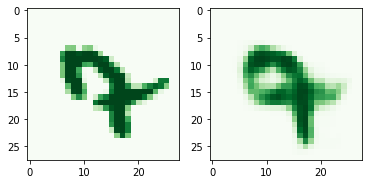

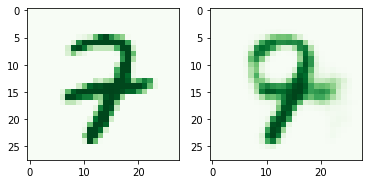

7 5
7 6
7 8
7 9


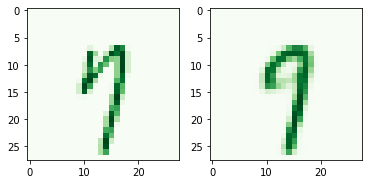

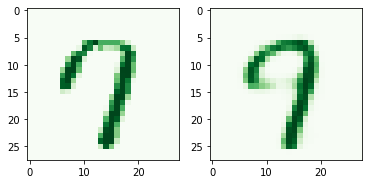

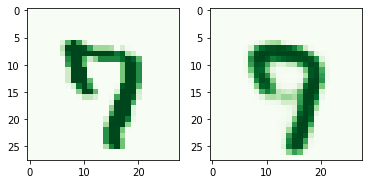

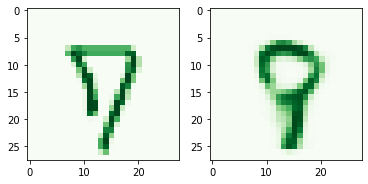

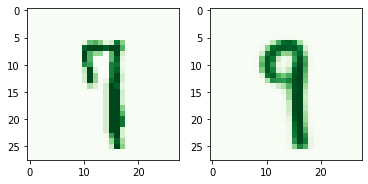

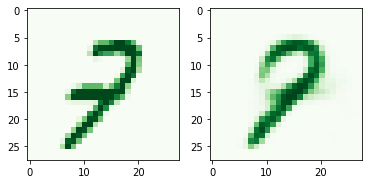

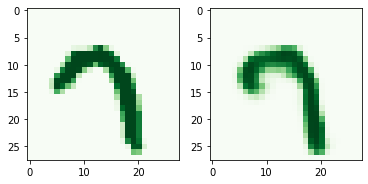

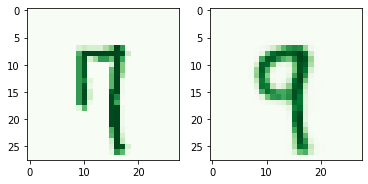

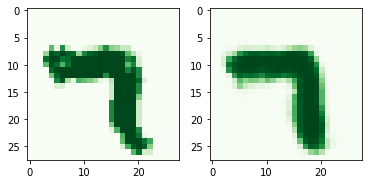

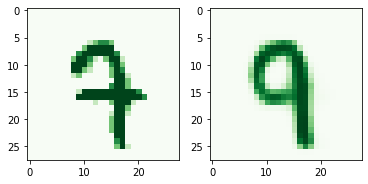

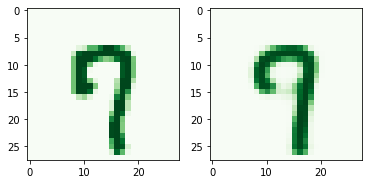

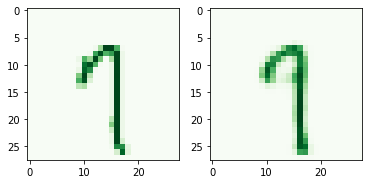

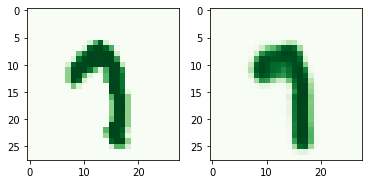

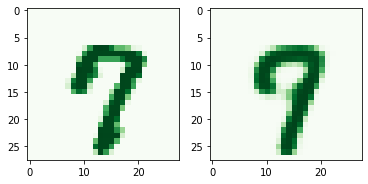

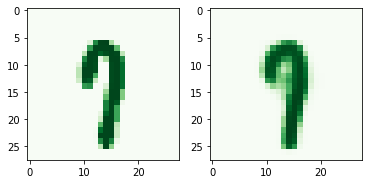

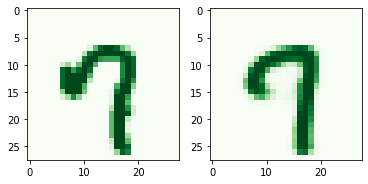

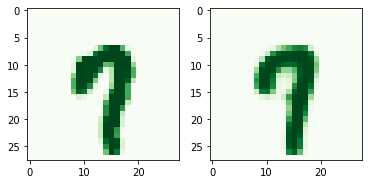

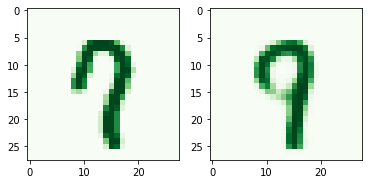

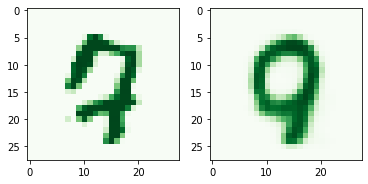

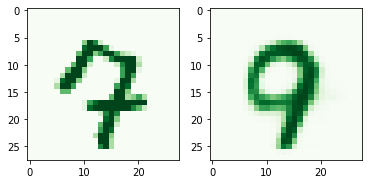

8 0


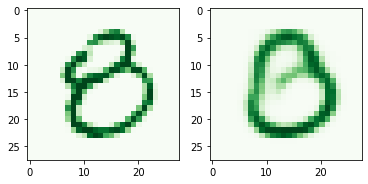

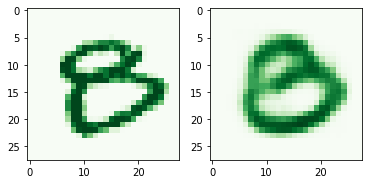

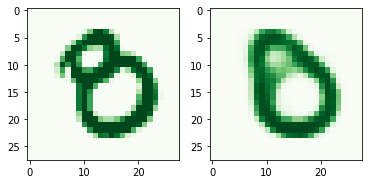

8 1


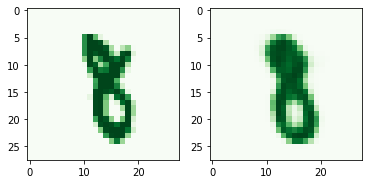

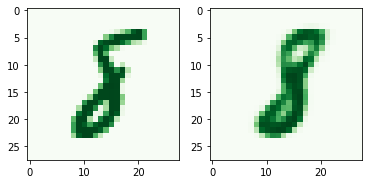

8 2


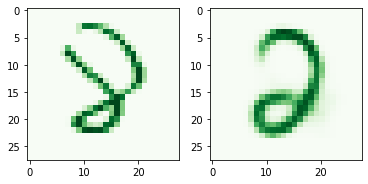

8 3


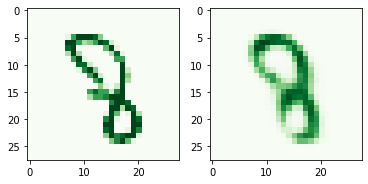

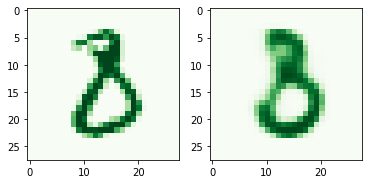

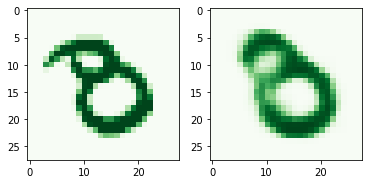

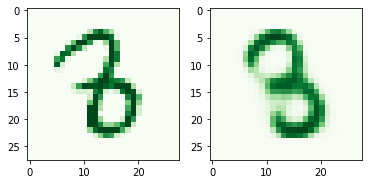

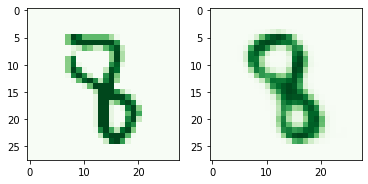

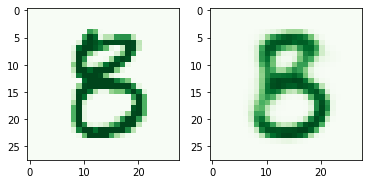

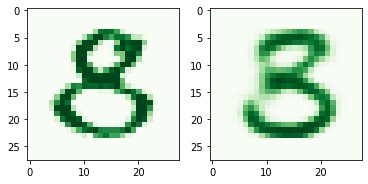

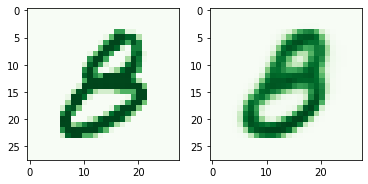

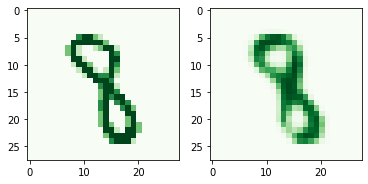

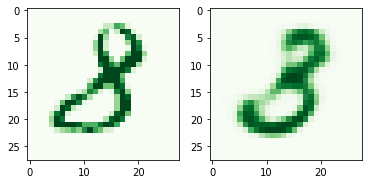

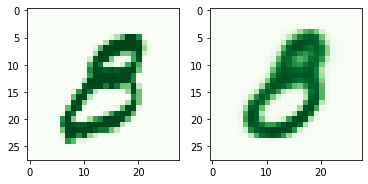

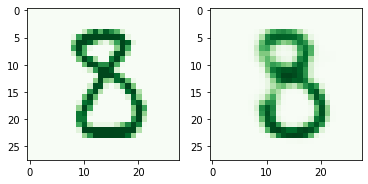

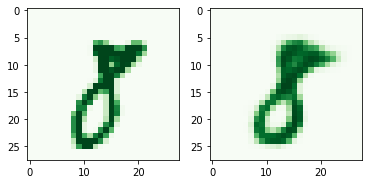

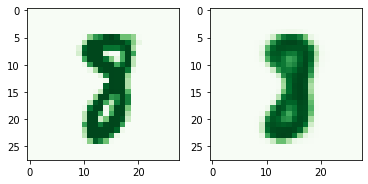

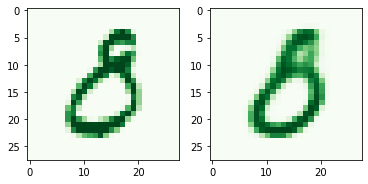

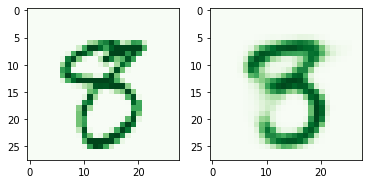

8 4


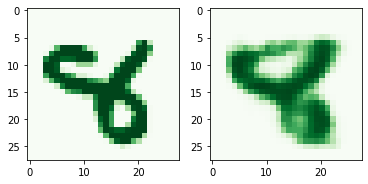

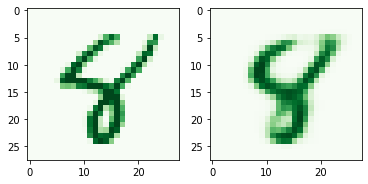

8 5


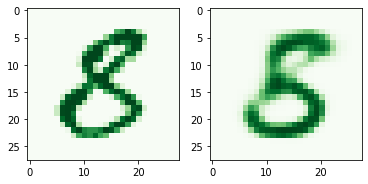

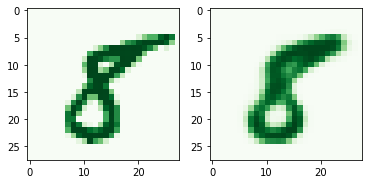

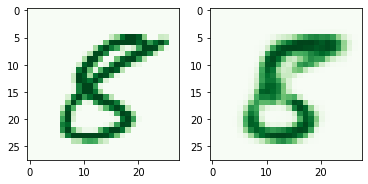

8 6


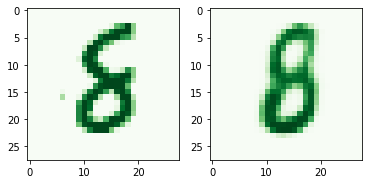

8 7


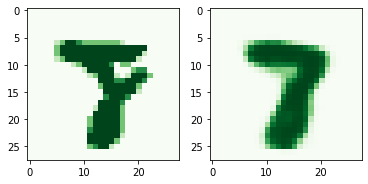

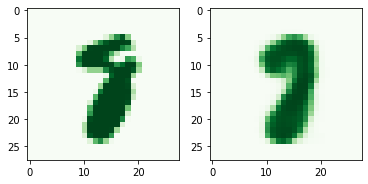

8 9


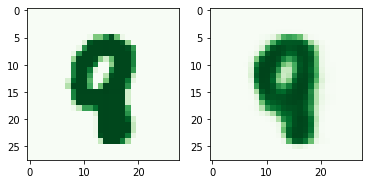

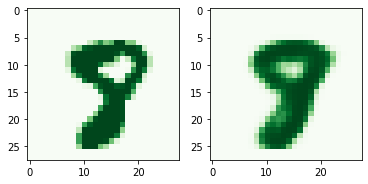

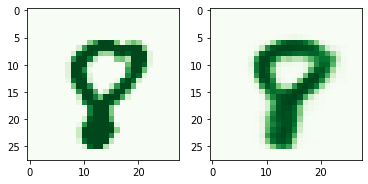

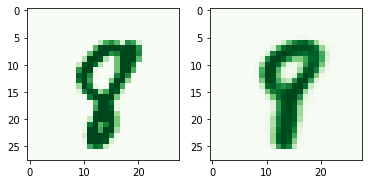

9 0


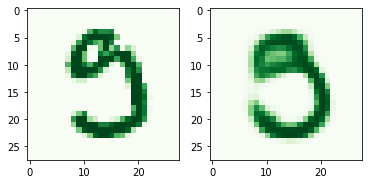

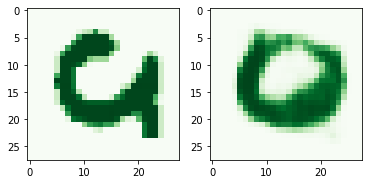

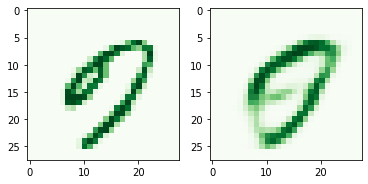

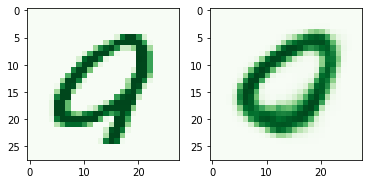

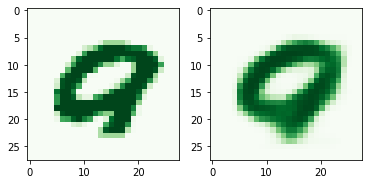

9 1


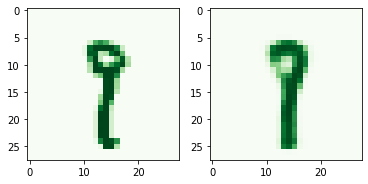

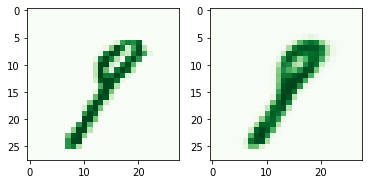

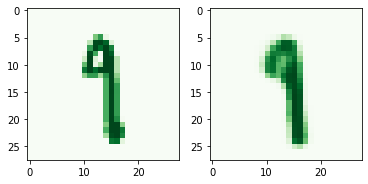

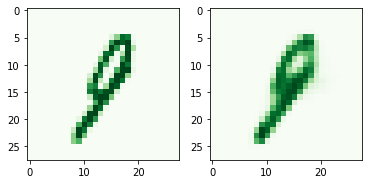

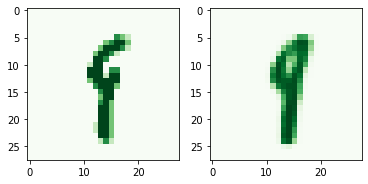

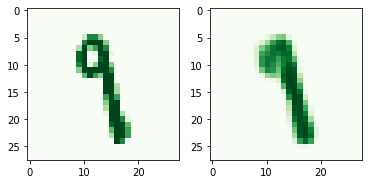

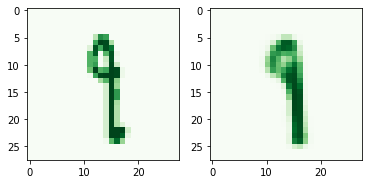

9 2


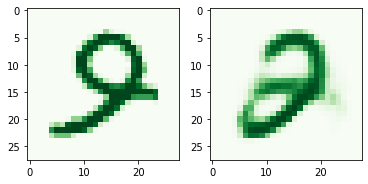

9 3


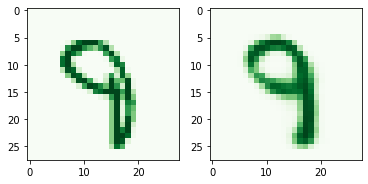

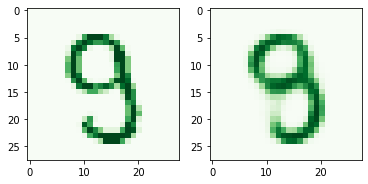

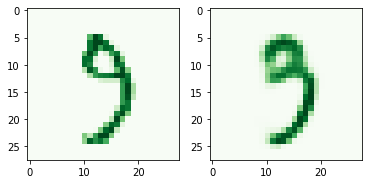

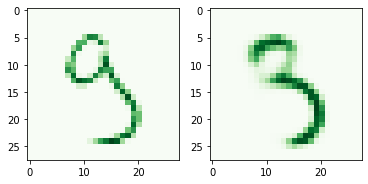

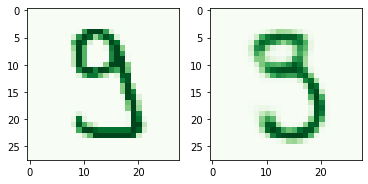

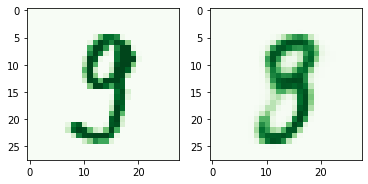

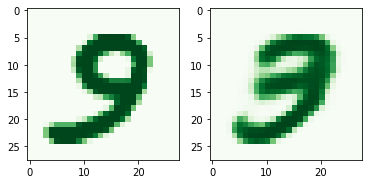

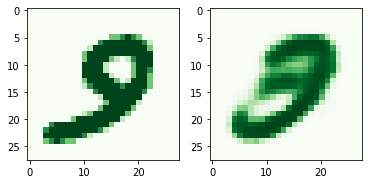

9 4


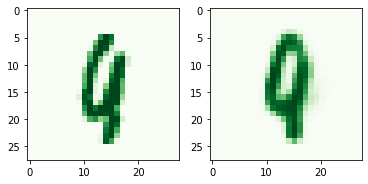

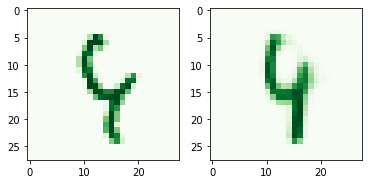

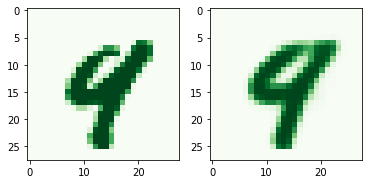

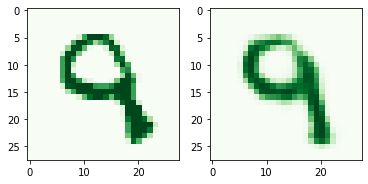

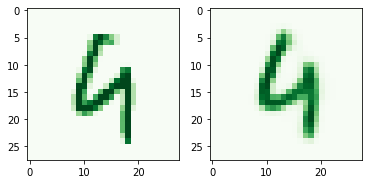

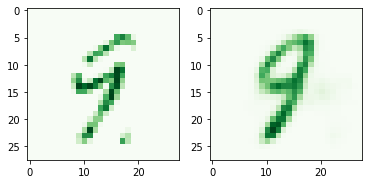

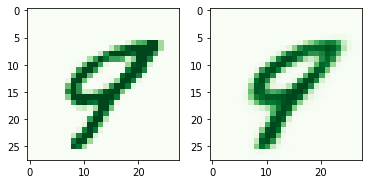

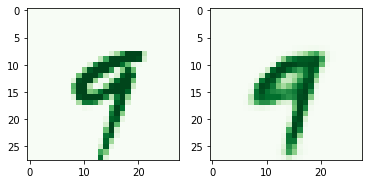

9 5
9 6
9 7


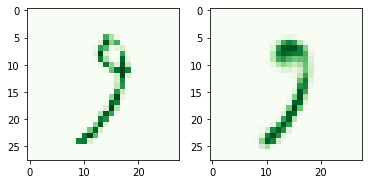

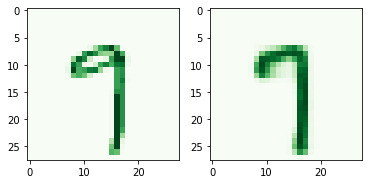

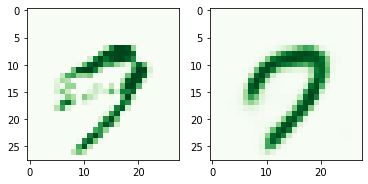

9 8


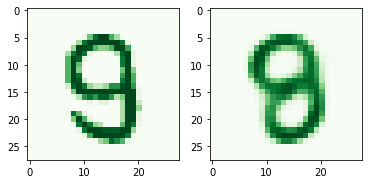

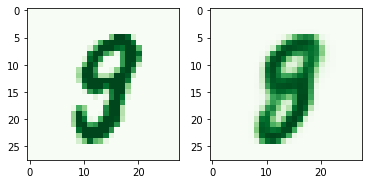

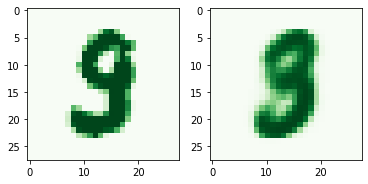

time: 2min 5s


In [13]:

for real in range(10):
    for pred in range(10):
        if real==pred:continue
        print(real, pred)
        for k in range(20):
            for y_true, y_pred, image in zip(y_test, test_pred, x_test):
                if y_true == real and y_pred == pred:
                    if k<0:break
                    s_image = image.reshape(1, 28,28,1)
                    s_encoded = encoder.predict(s_image)
                    s_decoded = decoder.predict(s_encoded,batch_size=1)
                    if np.argmax(teacher_model.predict(s_decoded))!=pred:continue
                    if k==0:
                        plt.subplot(121)
                        plt.imshow(s_image[0, :,:,0],cmap='Greens')
                        plt.subplot(122)
                        plt.imshow(s_decoded[0, :,:,0],cmap='Greens')
                        plt.show()
                    k-=1



# example 1

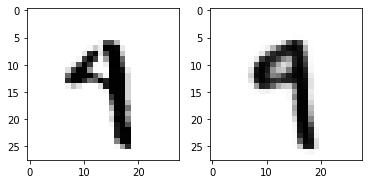

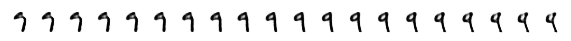

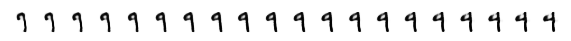

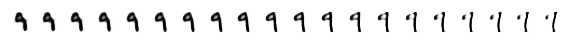

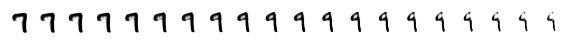

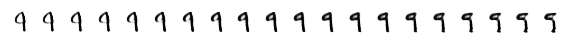

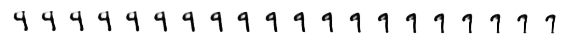

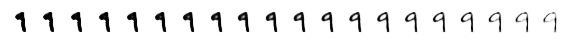

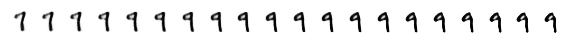

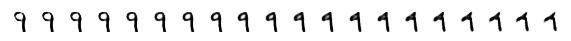

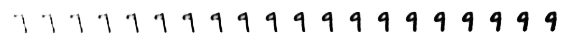

In [11]:
real = 4
pred = 9
step_size= 1
k = 2

if True:
    for y_true, y_pred, image in zip(y_test, test_pred, x_test):
        if y_true == real and y_pred == pred:
            if k<0:break
            s_image = image.reshape(1, 28,28,1)
            s_encoded = encoder.predict(s_image)
            s_decoded = decoder.predict(s_encoded,batch_size=1)
            if np.argmax(teacher_model.predict(s_decoded))!=pred:continue
            if k==0:
                plt.subplot(121)
                plt.imshow(s_image[0, :,:,0],cmap='Greys')
                plt.subplot(122)
                plt.imshow(s_decoded[0, :,:,0],cmap='Greys')
                plt.show()
            k-=1
n=20
digit_size=28
for k in range(10):
    change = np.zeros((1,latent_dim))
    change[0, k]= step_size
    d1_encoded = change*2 + s_encoded
    d1_decoded = decoder.predict(d1_encoded,batch_size=1)

    d2_encoded = s_encoded - change*2  
    d2_decoded = decoder.predict(d2_encoded,batch_size=1)

    from matplotlib import cm
    from scipy.interpolate import interp1d

    c_dict = {real:"Purples", pred:"Oranges"}
    plt.figure(figsize=(10, 10))
    
    label_proba = [[] for _ in range(n)]
    linfit1 = interp1d([0,n-1], np.vstack([d2_encoded, d1_encoded]), axis=0)
            
    for i in range(n):
        
        z_sample = linfit1(i)
        
        x_decoded = decoder.predict(z_sample.reshape(1,-1), batch_size=1)
        digit = x_decoded

        label = teacher_model.predict(digit)
        label_proba[i] = label[0]
            
        image = digit[0].reshape(digit_size, digit_size)
        plt.subplot(n,n, i+1)
        try:
            # plt.imshow(image, cmap=c_dict[np.argmax(label)])
            plt.imshow(image, cmap="Greys")
        except:
            #plt.imshow(image, cmap="GRAY")
            plt.imshow(image, cmap="Greys")
        plt.axis('off') 
    
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show() 
    
#     print("probability being", real, np.around(label_proba, 1)[:,real])
#     print("probability being", pred, np.around(label_proba, 1)[:,pred])
#     print("predicted label", np.argmax(label_proba, axis=1))
#     print("predicted label", np.max(np.around(label_proba, 1), axis=1))

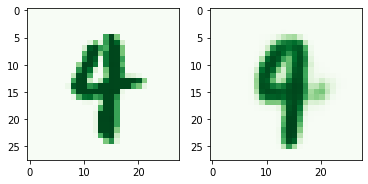

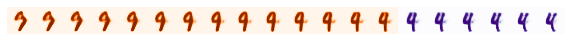

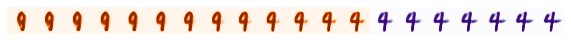

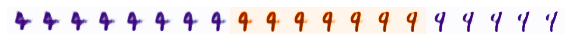

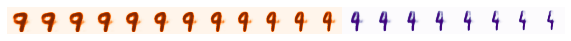

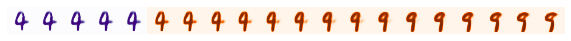

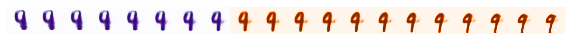

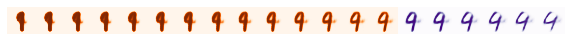

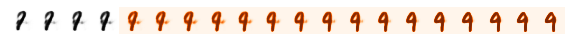

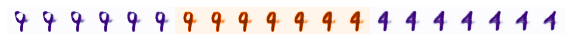

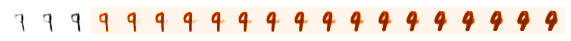

In [12]:
real = 4
pred = 9
step_size= 1
k = 1

if True:
    for y_true, y_pred, image in zip(y_test, test_pred, x_test):
        if y_true == real and y_pred == pred:
            if k<0:break
            s_image = image.reshape(1, 28,28,1)
            s_encoded = encoder.predict(s_image)
            s_decoded = decoder.predict(s_encoded,batch_size=1)
            if np.argmax(teacher_model.predict(s_decoded))!=pred:continue
            if k==0:
                plt.subplot(121)
                plt.imshow(s_image[0, :,:,0],cmap='Greens')
                plt.subplot(122)
                plt.imshow(s_decoded[0, :,:,0],cmap='Greens')
                plt.show()
            k-=1
n=20
digit_size=28
for k in range(10):
    change = np.zeros((1,latent_dim))
    change[0, k]= step_size
    d1_encoded = change*2 + s_encoded
    d1_decoded = decoder.predict(d1_encoded,batch_size=1)

    d2_encoded = s_encoded - change*2  
    d2_decoded = decoder.predict(d2_encoded,batch_size=1)

    from matplotlib import cm
    from scipy.interpolate import interp1d

    c_dict = {real:"Purples", pred:"Oranges"}
    plt.figure(figsize=(10, 10))
    
    label_proba = [[] for _ in range(n)]
    linfit1 = interp1d([0,n-1], np.vstack([d2_encoded, d1_encoded]), axis=0)
            
    for i in range(n):
        
        z_sample = linfit1(i)
        
        x_decoded = decoder.predict(z_sample.reshape(1,-1), batch_size=1)
        digit = x_decoded

        label = teacher_model.predict(digit)
        label_proba[i] = label[0]
            
        image = digit[0].reshape(digit_size, digit_size)
        plt.subplot(n,n, i+1)
        try:
            plt.imshow(image, cmap=c_dict[np.argmax(label)])
        except:
            plt.imshow(image, cmap="Greys")
        plt.axis('off') 


    
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show() 
    
#     print("probability being", real, np.around(label_proba, 1)[:,real])
#     print("probability being", pred, np.around(label_proba, 1)[:,pred])
#     print("predicted label", np.argmax(label_proba, axis=1))
#     print("predicted proba", np.max(np.around(label_proba, 1), axis=1))

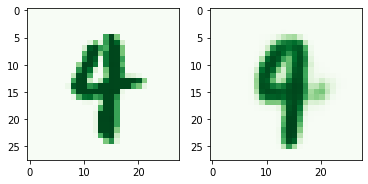

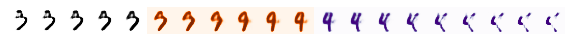

probability being 4 [0.  0.  0.  0.  0.  0.  0.  0.  0.1 0.2 0.2 0.6 0.9 1.  0.9 0.9 0.9 0.8
 0.8 0.7]
probability being 9 [0.  0.1 0.1 0.1 0.2 0.5 0.8 1.  0.9 0.8 0.7 0.4 0.1 0.  0.  0.  0.  0.
 0.  0. ]
predicted label [7 7 7 7 7 9 9 9 9 9 9 4 4 4 4 4 4 4 4 4]
predicted proba [0.6 0.8 0.9 0.9 0.8 0.5 0.8 1.  0.9 0.8 0.7 0.6 0.9 1.  0.9 0.9 0.9 0.8
 0.8 0.7]


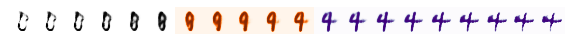

probability being 4 [0.  0.  0.  0.  0.  0.  0.1 0.2 0.2 0.2 0.3 0.7 0.9 1.  1.  1.  1.  1.
 1.  1. ]
probability being 9 [0.  0.  0.  0.  0.  0.2 0.4 0.6 0.8 0.8 0.7 0.3 0.  0.  0.  0.  0.  0.
 0.  0. ]
predicted label [8 8 8 8 8 8 9 9 9 9 9 4 4 4 4 4 4 4 4 4]
predicted proba [0.4 0.5 0.6 0.6 0.7 0.6 0.4 0.6 0.8 0.8 0.7 0.7 0.9 1.  1.  1.  1.  1.
 1.  1. ]


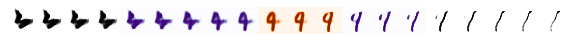

probability being 4 [0.  0.1 0.2 0.5 0.7 0.9 1.  1.  1.  0.5 0.1 0.4 0.8 0.7 0.5 0.3 0.2 0.2
 0.2 0.2]
probability being 9 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5 0.9 0.6 0.2 0.2 0.2 0.1 0.1 0.1
 0.1 0.1]
predicted label [6 6 6 6 4 4 4 4 4 9 9 9 4 4 4 7 7 7 7 7]
predicted proba [1.  0.9 0.8 0.5 0.7 0.9 1.  1.  1.  0.5 0.9 0.6 0.8 0.7 0.5 0.4 0.5 0.5
 0.4 0.3]


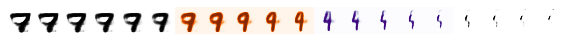

probability being 4 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.1 0.4 0.9 0.9 0.6 0.4 0.4 0.4 0.3
 0.3 0.2]
probability being 9 [0.  0.  0.  0.  0.  0.2 0.6 1.  1.  0.9 0.5 0.1 0.  0.  0.  0.  0.  0.
 0.  0. ]
predicted label [7 7 7 7 7 7 9 9 9 9 9 4 4 4 4 4 5 5 5 5]
predicted proba [1.  1.  1.  1.  1.  0.8 0.6 1.  1.  0.9 0.5 0.9 0.9 0.6 0.4 0.4 0.4 0.4
 0.4 0.4]


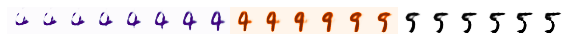

probability being 4 [0.5 0.6 0.7 0.8 0.8 0.8 0.7 0.6 0.5 0.3 0.1 0.  0.  0.  0.  0.  0.  0.
 0.  0. ]
probability being 9 [0.1 0.1 0.1 0.1 0.1 0.2 0.3 0.4 0.5 0.7 0.9 1.  0.8 0.6 0.4 0.1 0.  0.
 0.  0. ]
predicted label [4 4 4 4 4 4 4 4 9 9 9 9 9 9 5 5 5 5 5 5]
predicted proba [0.5 0.6 0.7 0.8 0.8 0.8 0.7 0.6 0.5 0.7 0.9 1.  0.8 0.6 0.5 0.9 1.  1.
 1.  1. ]


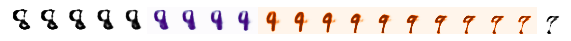

probability being 4 [0.  0.  0.  0.1 0.3 0.6 0.9 1.  0.9 0.4 0.1 0.1 0.2 0.4 0.4 0.3 0.2 0.1
 0.  0. ]
probability being 9 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.6 0.9 0.9 0.8 0.5 0.6 0.6 0.6 0.6
 0.5 0.4]
predicted label [5 8 3 3 3 4 4 4 4 9 9 9 9 9 9 9 9 9 9 7]
predicted proba [0.4 0.4 0.5 0.5 0.5 0.6 0.9 1.  0.9 0.6 0.9 0.9 0.8 0.5 0.6 0.6 0.6 0.6
 0.5 0.6]


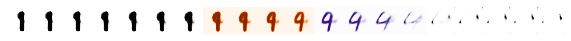

probability being 4 [0.  0.  0.  0.  0.  0.  0.  0.  0.1 0.2 0.2 0.6 0.9 0.8 0.4 0.1 0.1 0.1
 0.  0. ]
probability being 9 [0.  0.  0.  0.1 0.2 0.3 0.4 0.7 0.8 0.8 0.7 0.4 0.1 0.1 0.1 0.1 0.1 0.
 0.  0. ]
predicted label [1 1 1 1 8 8 8 9 9 9 9 4 4 4 4 0 0 0 0 0]
predicted proba [0.9 0.9 0.8 0.6 0.4 0.5 0.5 0.7 0.8 0.8 0.7 0.6 0.9 0.8 0.4 0.2 0.2 0.3
 0.3 0.3]


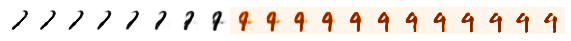

probability being 4 [0.  0.  0.  0.  0.  0.  0.  0.  0.1 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.1
 0.1 0. ]
probability being 9 [0.  0.  0.  0.  0.  0.  0.  0.2 0.7 0.8 0.8 0.8 0.8 0.8 0.9 0.9 0.9 0.9
 0.9 1. ]
predicted label [1 1 2 2 2 2 8 8 9 9 9 9 9 9 9 9 9 9 9 9]
predicted proba [0.4 0.4 0.4 0.4 0.4 0.5 0.5 0.8 0.7 0.8 0.8 0.8 0.8 0.8 0.9 0.9 0.9 0.9
 0.9 1. ]


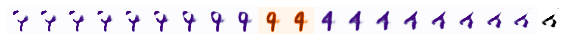

probability being 4 [0.8 0.9 0.9 0.9 1.  1.  1.  0.9 0.5 0.2 0.2 0.8 1.  1.  1.  1.  0.9 0.8
 0.6 0.5]
probability being 9 [0.  0.  0.  0.  0.  0.  0.  0.  0.5 0.8 0.7 0.2 0.  0.  0.  0.  0.  0.
 0.  0. ]
predicted label [4 4 4 4 4 4 4 4 4 9 9 4 4 4 4 4 4 4 4 5]
predicted proba [0.8 0.9 0.9 0.9 1.  1.  1.  0.9 0.5 0.8 0.7 0.8 1.  1.  1.  1.  0.9 0.8
 0.6 0.5]


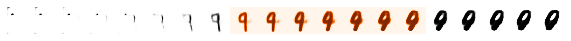

probability being 4 [0.1 0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0.1 0.3 0.3 0.2 0.2 0.1 0.1 0.  0.
 0.  0. ]
probability being 9 [0.  0.1 0.1 0.1 0.1 0.1 0.  0.2 0.9 0.9 0.7 0.7 0.7 0.8 0.7 0.4 0.1 0.
 0.  0. ]
predicted label [7 7 7 7 1 1 1 1 9 9 9 9 9 9 9 8 8 8 8 6]
predicted proba [0.2 0.2 0.2 0.2 0.2 0.4 0.8 0.7 0.9 0.9 0.7 0.7 0.7 0.8 0.7 0.5 0.8 0.8
 0.6 0.5]
time: 8.04 s


In [25]:
real = 4
pred = 9
step_size_left = 3
step_size_right = 3


k = 1

if True:
    for y_true, y_pred, image in zip(y_test, test_pred, x_test):
        if y_true == real and y_pred == pred:
            if k<0:break
            s_image = image.reshape(1, 28,28,1)
            s_encoded = encoder.predict(s_image)
            s_decoded = decoder.predict(s_encoded,batch_size=1)
            if np.argmax(teacher_model.predict(s_decoded))!=pred:continue
            if k==0:
                plt.subplot(121)
                plt.imshow(s_image[0, :,:,0],cmap='Greens')
                plt.subplot(122)
                plt.imshow(s_decoded[0, :,:,0],cmap='Greens')
                plt.show()
            k-=1
n=20
digit_size=28
decoded_list = []

for k in range(10):
    
    change = np.zeros((1,latent_dim))
    change[0, k]= step_size_right
    d1_encoded = change*2 + s_encoded
    d1_decoded = decoder.predict(d1_encoded,batch_size=1)

    change = np.zeros((1,latent_dim))
    change[0, k]= step_size_left
    d2_encoded = s_encoded - change*2  
    d2_decoded = decoder.predict(d2_encoded,batch_size=1)

    from matplotlib import cm
    from scipy.interpolate import interp1d

    c_dict = {real:"Purples", pred:"Oranges"}
    plt.figure(figsize=(10, 10))
    
    label_proba = [[] for _ in range(n)]
    linfit1 = interp1d([0,n-1], np.vstack([d2_encoded, d1_encoded]), axis=0)
    
    decoded_list_column = []
    for i in range(n):
        
        z_sample = linfit1(i)
        decoded_list_column.append(z_sample)
        
        x_decoded = decoder.predict(z_sample.reshape(1,-1), batch_size=1)
        
        
        digit = x_decoded

        label = teacher_model.predict(digit)
        label_proba[i] = label[0]
            
        image = digit[0].reshape(digit_size, digit_size)
        
        
        plt.subplot(n,n, i+1)
        try:
            plt.imshow(image, cmap=c_dict[np.argmax(label)])
        except:
            plt.imshow(image, cmap="Greys")
        plt.axis('off') 

    decoded_list.append(decoded_list_column)
    
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show() 
    
    print("probability being", real, np.around(label_proba, 1)[:,real])
    print("probability being", pred, np.around(label_proba, 1)[:,pred])
    print("predicted label", np.argmax(label_proba, axis=1))
    print("predicted proba", np.max(np.around(label_proba, 1), axis=1))

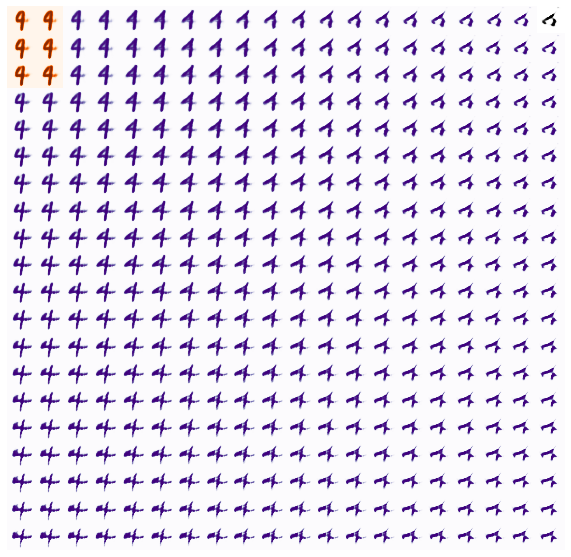

time: 15 s


In [28]:
plt.figure(figsize=(10, 10))
if True:
    
    linfit1 = interp1d([0,n-1], np.vstack([s_encoded, decoded_list[1][-1]]), axis=0)
    linfit2 = interp1d([0,n-1], np.vstack([s_encoded, decoded_list[-2][-1]]), axis=0)
            
    for i in range(n):
        for j in range(n):
        
            z_sample = s_encoded + (linfit1(i)-s_encoded) + (linfit2(j)-s_encoded) 
        
            x_decoded = decoder.predict(z_sample.reshape(1,-1), batch_size=1)
            digit = x_decoded

            label = teacher_model.predict(digit)
            image = digit[0].reshape(digit_size, digit_size)
            plt.subplot(n,n, i*n+j+1)
            try:
                plt.imshow(image, cmap=c_dict[np.argmax(label)])
            except:
                plt.imshow(image, cmap="Greys")
            plt.axis('off') 
                
        
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show() 

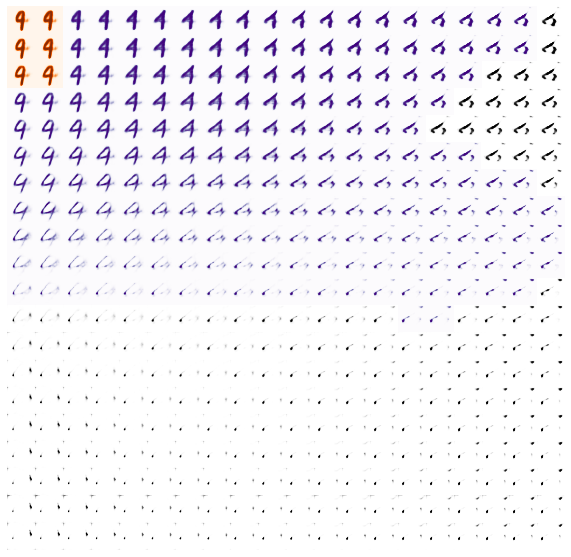

time: 16.1 s


In [29]:
plt.figure(figsize=(10, 10))
if True:
    
    linfit1 = interp1d([0,n-1], np.vstack([s_encoded, decoded_list[-4][-1]]), axis=0)
    linfit2 = interp1d([0,n-1], np.vstack([s_encoded, decoded_list[-2][-1]]), axis=0)
            
    for i in range(n):
        for j in range(n):
        
            z_sample = s_encoded + (linfit1(i)-s_encoded) + (linfit2(j)-s_encoded) 
        
            x_decoded = decoder.predict(z_sample.reshape(1,-1), batch_size=1)
            digit = x_decoded

            label = teacher_model.predict(digit)
            image = digit[0].reshape(digit_size, digit_size)
            plt.subplot(n,n, i*n+j+1)
            try:
                plt.imshow(image, cmap=c_dict[np.argmax(label)])
            except:
                plt.imshow(image, cmap="Greys")
            plt.axis('off') 
                
        
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show() 